# Epidemic Model Simulation

### SI Model Implementation

In [1]:
import random
import operator
import powerlaw
import numpy as np
import collections
import pandas as pd
import numpy as np 
import networkx as nx
import matplotlib.cm as cm
from pylab import rcParams
from itertools import count
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import pyplot, patches 
from numpy.random import default_rng
from community import community_louvain
from timeit import default_timer as timer
from collections import defaultdict, Counter

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
def SI_model(G, initial_infecteds, beta, t_simulation):
    """
    This function performs the SI model simulation for a given time

    Parameters
    ----------
    G : graph
      A NetworkX graph

    initial_infecteds : list
      The list of nodes to be infected on Day 0

    beta: float
         the transmission rate of the disease
         
    t_simulation : int, 
      No of days of simulation
      
    Returns
    ----------
    overall_status_dict: dict
        the day-wise status of all nodes
    """
    
    # Initial Parameters
    pop_size = len(G.nodes)
    initial_infecteds   = np.array(initial_infecteds)
    overall_status_dict = collections.defaultdict(list)
    
    infected_on_day     = np.full(pop_size, -99) # setting all the nodes as not infected by setting the infected on day as '-99'
    current_status_list = np.full(pop_size, 'S') # declaring all nodes as 'S' (SUSCEPTIBLE) initially
    
    current_status_list[initial_infecteds -1 ] = 'I' # Updating the status of the initial infected nodes as 'I' (INFECTED)
    infected_on_day[initial_infecteds -1 ] = 0 # Updating the 'day' of infection to day 0

    overall_status_dict[0] = current_status_list.copy() # Updating Day-0 status to overall status dictonary

    for t in range(1, t_simulation+1):
        infected_list = np.where(current_status_list=='I')[0] + 1 # Get all current infected nodes' index
        
        #Start infection process
        for infected in infected_list:
            neighbours = list(G.neighbors(infected)) # get list of neighbors
            for n in neighbours:
                node_index = n-1
                if current_status_list[node_index] == 'S': # Checking if the neighbor is susceptible
                    rand_num = np.random.uniform(0,1) # Generate a random number between 0 and 1
                    # Infect the node if the beta is greater than the random number
                    if rand_num <= beta: 
                        current_status_list[node_index] = 'I' # Updating the status to Infected
                        infected_on_day[node_index] = t # Updating the 'day' of infection to day 't'
        overall_status_dict[t] = current_status_list.copy() # Updating daily status
    
    return overall_status_dict

def draw_SI_summary_plot(average_status_dict, no_of_simulations):
    """
    This function plots the summary of the simulation

    Parameters
    ----------
    average_status_dict: dict
        the day-wise status of all nodes
         
    no_of_simulations : int, 
      No of days of simulation

    """
    no_of_simulations = 100
    S_Data = [] # Susceptible data
    I_Data = [] # Infected data
    
    # Get Day-wise data
    for t, status in average_status_dict.items():
        status_on_day_t = collections.Counter(status)
        S_Data.append(status_on_day_t['S']/no_of_simulations) 
        I_Data.append(status_on_day_t['I']/no_of_simulations)
    
    # plot the graph
    plt.figure(figsize = (7,5))
    plt.title('SI Model')
    plt.xlabel('Days(t)')
    plt.ylabel('No of Nodes')
    plt.plot(range(0, t_simulation+1), S_Data, label="SUSCEPTIBLE", color = 'g')
    plt.plot(range(0, t_simulation+1), I_Data, label="INFECTED", color='r')
    plt.legend()
    plt.show()
    
def draw_SI_model_progress(G, pos, overall_status_dict):
    """
    This function plots the day wise summary of the simulation

    Parameters
    ----------
    G : graph
      A NetworkX graph

    pos : dictionary, 
      A dictionary with nodes as keys and positions as values.
    
    overall_status_dict: dict
        the day-wise status of all nodes

    """
    # Creating a graph with 4 * 3 subplots
    fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize=(20,20))
    ax = axes.flatten()
    S_COLOR = 'GREEN'
    I_COLOR = 'BROWN'
    days = [1, 15, 30, 60, 90, 120, 150, 180, 210, 240, 270,300] # Days on which status will be plotted
    fig.suptitle('Daywise status of a Simulation', y=0.92) # Adding title
    
    for i in range(len(days)):
        node_color = np.full(len(G.nodes), S_COLOR) # Setting all nodes to Susceptible
        infected_nodes_index = np.where(overall_status_dict[days[i]] == 'I') # get list of infected nodes
        ax[i].set_title(f'Status on Day {days[i]}' )
        node_color[infected_nodes_index] = I_COLOR # Changing color of infected nodes
        
        # Plot the graph
        ec = nx.draw_networkx_edges(G, pos, alpha = 0.1, ax=ax[i])
        nc = nx.draw_networkx_nodes(G, pos, alpha = 0.8, node_color = node_color, node_size = 10, 
                                    ax=ax[i], cmap = plt.cm.Set1)
        
        S_count = collections.Counter(overall_status_dict[days[i]])['S']
        I_count = collections.Counter(overall_status_dict[days[i]])['I']
        # Plotting Legend
        ax[i].plot([],[], label= f'SUSCEPTIBLE : {S_count}', color = S_COLOR)
        ax[i].plot([],[], label= f'INFECTED : {I_count}', color = I_COLOR)
        ax[i].legend( loc = 'best')

    plt.show()

### SI Model Simulation

In [3]:
def simulate_SI(G, no_of_simulations, t_simulation, beta):
    """
    This function repeats the SI model simulation for a given number of times

    Parameters
    ----------
    G : graph
      A NetworkX graph

    no_of_simulations : int
      No of times to repeat the simulation

    beta: float
         the transmission rate of the disease
         
    t_simulation : int, 
      No of days of simulation
      
    Returns
    ----------
    average_status_dict_SI: dict
        the average day-wise status of all nodes on all simulations
    """
    start = timer() # start timer
    average_status_dict_SI = defaultdict(dict)
    # Initialising the status dictionary
    for i in range(t_simulation+1):
        average_status_dict_SI[i] = {'S': 0, 'I' : 0}
    
    # Calculating daily average
    for i in range(no_of_simulations):
        initial_infecteds = np.random.choice(len(G.nodes), 3)
        overall_status_dict_SI = SI_model(G, initial_infecteds = initial_infecteds, beta = 0.01, t_simulation = 300)
        for time, status in overall_status_dict_SI.items():
            average_status_dict_SI[time]['S'] += Counter(status).get('S', 0)
            average_status_dict_SI[time]['I'] += Counter(status).get('I', 0)
    end = timer() # end timer

    print(f"No of Simulations: {no_of_simulations} \nTime taken: {round(end - start, 2)} Seconds")
    draw_SI_summary_plot(average_status_dict_SI, no_of_simulations) # Plot the final Summary
    print("\n")
    pos = nx.spring_layout(G)
    draw_SI_model_progress(G, pos, overall_status_dict_SI) # Plot the daily progress on a random simulation
    return average_status_dict_SI

No of Simulations: 100 
Time taken: 58.14 Seconds


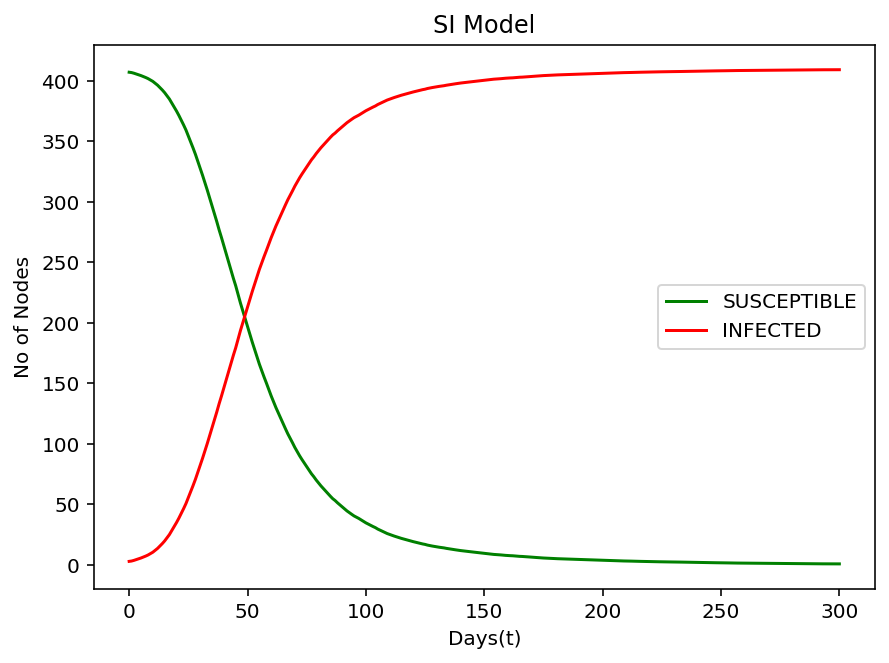

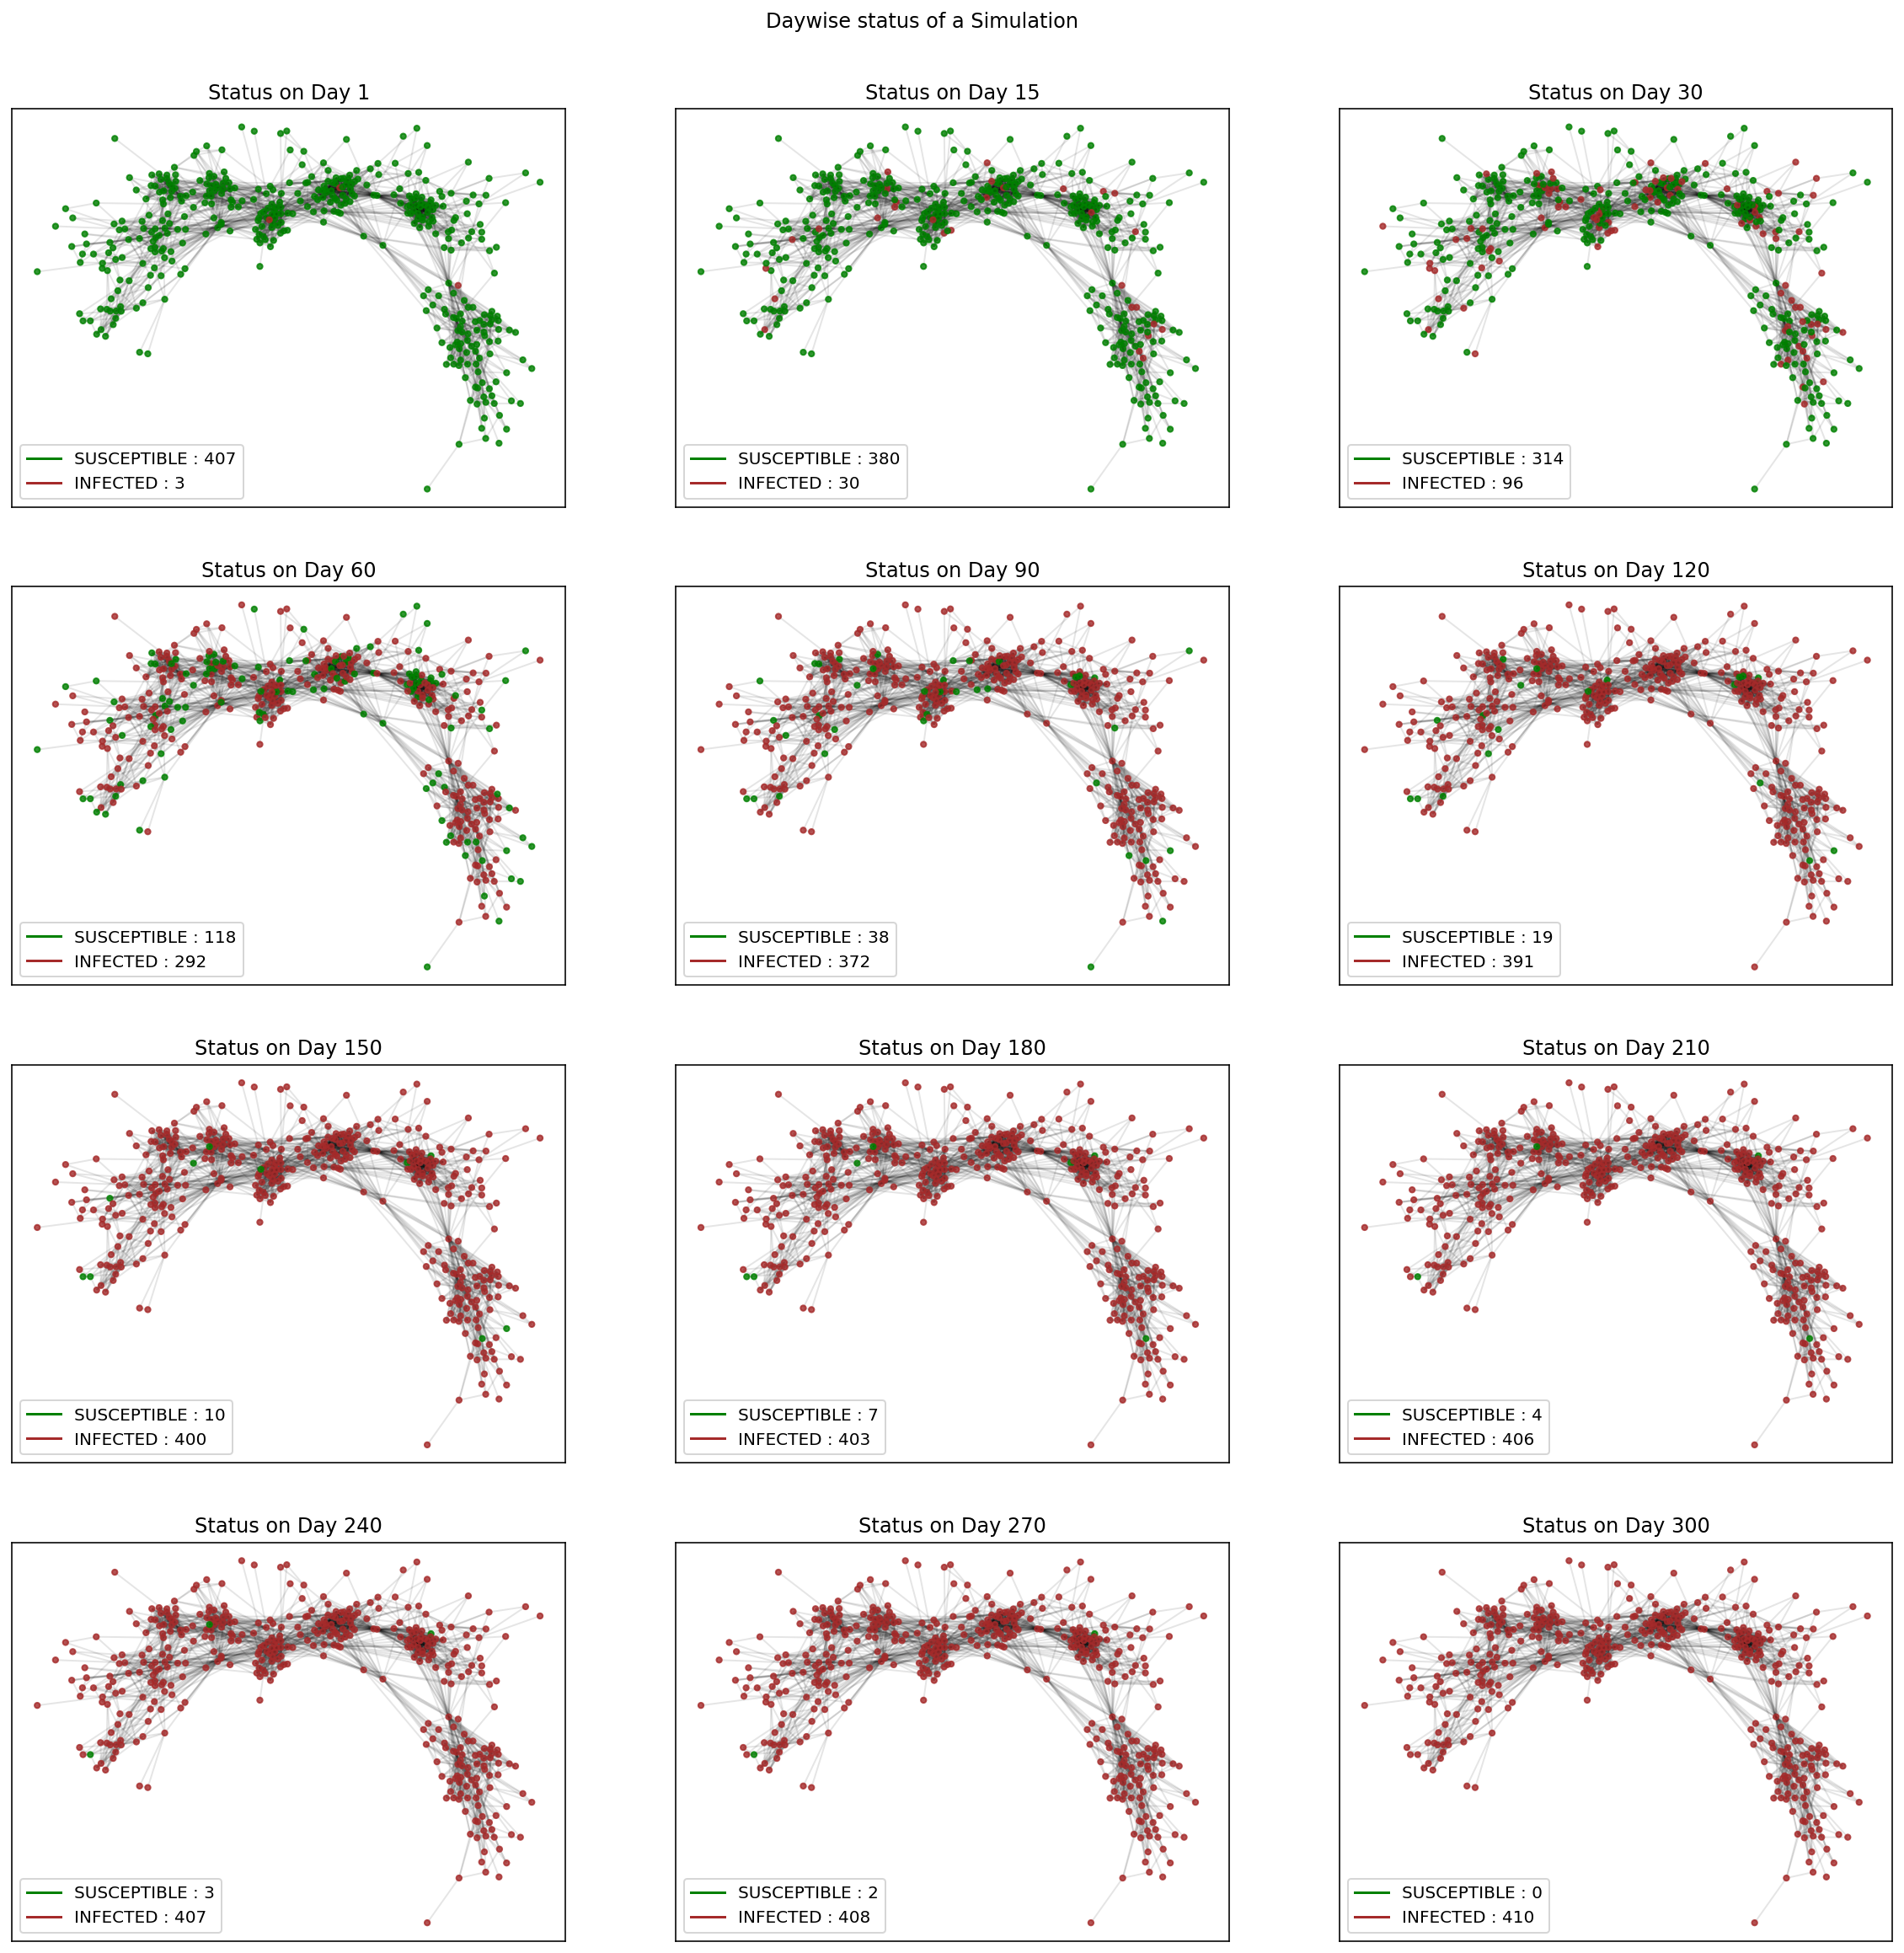

In [4]:
 # Run SI Model Simulation
Gx = nx.read_edgelist('infect-dublin.edges', nodetype = int )
no_of_simulations = 100
t_simulation = 300
start = timer()
beta = 0.001
average_status_dict_SI = simulate_SI(Gx, no_of_simulations, t_simulation, beta)

### SIR Model Implementation

In [5]:
def SIR_model(G, initial_infecteds , beta, t_simulation, recovery_time, immune_nodes):
    """
    This function performs the SIR model simulation for a given time

    Parameters
    ----------
    G : graph
      A NetworkX graph

    initial_infecteds : list
      The list of nodes to be infected on Day 0

    beta: float
         the transmission rate of the disease
         
    t_simulation : int, 
      No of days of simulation
    
    recovery_time : int
      Time taken to get recovered
      
    immune_nodes : list
      list of nodes that are immune to the disease
    
    Returns
    ----------
    overall_status_dict: dict
        the day-wise status of all nodes
    """
    recovery_time = recovery_time
    initial_infecteds     = np.array(initial_infecteds)
    immune_nodes         = np.array(immune_nodes)
    overall_status_dict   = collections.defaultdict(list)
    
    # Setting initial Parameters
    infected_on_day       = np.full(len(G.nodes), -99) # setting all the nodes as not infected ever (-99)
    current_status_list   = np.full(len(G.nodes), 'S') # declaring all nodes as 'S' (SUSCEPTIBLE) initially
    ### nodes_recovery_status = np.full(len(G.nodes), -99) # setting all the nodes as not infected ever (-99)
    
    # Update the status of the initial infected nodes
    current_status_list[initial_infecteds -1 ]   = 'I'
    current_status_list[immune_nodes -1]   = 'V'
    
    infected_on_day[initial_infecteds -1 ]       =  0
    overall_status_dict[0] = current_status_list.copy()

    for t in range(1, t_simulation+1):
        # Get all current infected nodes' index
        infected_list = np.where(current_status_list == 'I')[0] + 1 

        #Start infection process
        for infected_node in infected_list:
            if infected_on_day[infected_node - 1] + recovery_time == t+1:
                current_status_list[infected_node -1 ] = 'R'
            else:
                neighbours = list(G.neighbors(infected_node)) # get list of neighbors
                for n in neighbours:
                    node_index = n-1
                    # Infecting susceptible neighbors if the beta is greater than the random number
                    if current_status_list[node_index] == 'S': 
                        rand_num = np.random.uniform(0,1)
                        if rand_num <= beta: 
                            current_status_list[node_index] = 'I' # Update the status of the infected node
                            infected_on_day[node_index] = t 
        overall_status_dict[t] = current_status_list.copy()

    return overall_status_dict


def draw_SIR_summary_plot(average_status_dict, no_of_simulations, title):
    """
    This function plots the summary of the SIR simulation

    Parameters
    ----------
    average_status_dict: dict
        the average day-wise status of all nodes
         
    no_of_simulations : int, 
      No of days of simulation
   
    title: str
      Title of the graph

    """
    no_of_simulations = 100
    S_Data = [] # Susceptible data
    I_Data = [] # Infected data
    R_Data = [] # Recovered data
    V_Data = [] # Vaccinated data
    
    # Get Day-wise data
    for t, status in average_status_dict.items():
        status_on_day_t = collections.Counter(status)
        S_Data.append(status_on_day_t['S']/no_of_simulations)
        I_Data.append(status_on_day_t['I']/no_of_simulations)
        R_Data.append(status_on_day_t['R']/no_of_simulations)
#         V_Data.append(status_on_day_t['V']/no_of_simulations)
    
    # Plot the Graph
    plt.figure(figsize = (6,4))
    plt.title(title)
    plt.xlabel('Days(t)')
    plt.ylabel('No of Nodes')
    plt.plot(range(0, t_simulation+1), S_Data, label="SUSCEPTIBLE", color = 'g')
    plt.plot(range(0, t_simulation+1), I_Data, label="INFECTED", color='r')
    plt.plot(range(0, t_simulation+1), R_Data, label="RECOVERED", color='b')
#     plt.plot(range(0, t_simulation+1), V_Data, label="VACC", color='y')
    plt.legend()
    plt.show()

    
def draw_SIR_model_progress(G, pos, overall_status_dict):
    """
    This function plots the day wise summary of the SIR simulation

    Parameters
    ----------
    G : graph
      A NetworkX graph

    pos : dictionary, 
      A dictionary with nodes as keys and positions as values.
    
    overall_status_dict: dict
        the day-wise status of all nodes

    """
    # Creating a graph with 4 * 3 subplots
    fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize=(20,20))
    ax = axes.flatten()

    S_COLOR = 'GREEN'
    I_COLOR = 'BROWN'
    R_COLOR = 'BLUE'
    V_COLOR = 'CYAN'
    days = [1, 15, 30, 60, 90, 120,150, 180, 210, 240, 270,300] # Days on which status will be plotted
    fig.suptitle('Daywise status of a Simulation', y=0.92) # Adding title
    for i in range(len(days)):
        node_color = np.full(len(G.nodes), 'PINK', dtype = "<U20") # Setting all nodes to Pink color initally
        
        # Getting the indices of the nodes of each status
        susceptible_nodes_index = np.where(overall_status_dict[days[i]] == 'S')
        infected_nodes_index    = np.where(overall_status_dict[days[i]] == 'I')
        recovered_nodes_index   = np.where(overall_status_dict[days[i]] == 'R')
        immune_nodes_index      = np.where(overall_status_dict[days[i]] == 'V')
        
        # Changing Color based on status
        node_color[susceptible_nodes_index] = S_COLOR
        node_color[infected_nodes_index]    = I_COLOR
        node_color[recovered_nodes_index]   = R_COLOR
        node_color[immune_nodes_index]      = V_COLOR

        ax[i].set_title(f'Status on Day {days[i]}' ) # Set title
        # Plot the Network
        ec = nx.draw_networkx_edges(G, pos, alpha = 0.1, ax=ax[i])
        nc = nx.draw_networkx_nodes(G, pos, alpha = 0.8, node_color = node_color, 
                                    node_size = 20, ax=ax[i], cmap = plt.cm.Set1)
        
        # Plotting Legend
        S_count = collections.Counter(overall_status_dict[days[i]])['S']
        I_count = collections.Counter(overall_status_dict[days[i]])['I']
        R_count = collections.Counter(overall_status_dict[days[i]])['R']
        V_count = collections.Counter(overall_status_dict[days[i]])['V']
        ax[i].plot([],[], label= f'SUSCEPTIBLE : {S_count}', color = S_COLOR)
        ax[i].plot([],[], label= f'INFECTED : {I_count}', color = I_COLOR)
        ax[i].plot([],[], label= f'RECOVERED : {R_count}', color = R_COLOR)
        ax[i].plot([],[], label= f'IMMUNE : {V_count}', color = V_COLOR)
        ax[i].legend( loc = 'best')
#         ax[i].set_axis_off()

    plt.show()

### SIR Model Simulation

In [6]:
def simulate_SIR(G, no_of_simulations, t_simulation, recovery_time, beta, immune_nodes):
    """
    This function repeats the SIR model simulation for a given number of times

    Parameters
    ----------
    G : graph
      A NetworkX graph

    no_of_simulations : int
      No of times to repeat the simulation

    beta: float
         the transmission rate of the disease
    
    recovery_time : int
      Time taken to get recovered
               
    t_simulation : int, 
      No of days of simulation
      
    immune_nodes : list
      list of nodes that are immune to the disease      
    Returns
    ----------
    average_status_dict_SI: dict
        the average day-wise status of all nodes on all simulations
    """
    start = timer() # start timer
    # Initialising the status dictionary
    average_status_dict_SIR = defaultdict(dict)
    
    for i in range(t_simulation+1):
        average_status_dict_SIR[i] = {'S': 0, 'I' : 0, 'R' : 0}
    # Calculating daily average 
    for i in range(no_of_simulations):
        initial_infecteds = np.random.choice(len(G.nodes), 3)
        overall_status_dict_SIR = SIR_model(G, initial_infecteds = initial_infecteds,\
                                    beta = beta, t_simulation = 300, recovery_time = recovery_time,\
                                    immune_nodes = [1,2,3,4,5,6,7,8,9,10])
        for time, status in overall_status_dict_SIR.items():
            average_status_dict_SIR[time]['S'] += Counter(status).get('S', 0)
            average_status_dict_SIR[time]['I'] += Counter(status).get('I', 0)
            average_status_dict_SIR[time]['R'] += Counter(status).get('R', 0)
    end = timer() # end timer

    print(f"No of Simulations: {no_of_simulations} \nTime taken: {round(end - start, 2)} Seconds")
    pos = nx.spring_layout(G)
    draw_SIR_summary_plot(average_status_dict_SIR, no_of_simulations, 'SIR Model') # Plot the final Summary
    print('\n')
    draw_SIR_model_progress(G, pos, overall_status_dict_SIR) # Plot the daily progress on a random simulation
    return average_status_dict_SIR

No of Simulations: 100 
Time taken: 8.66 Seconds


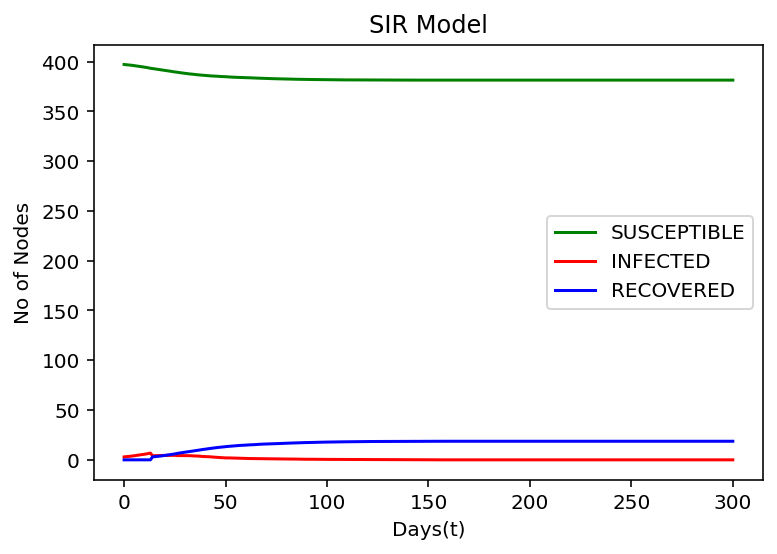

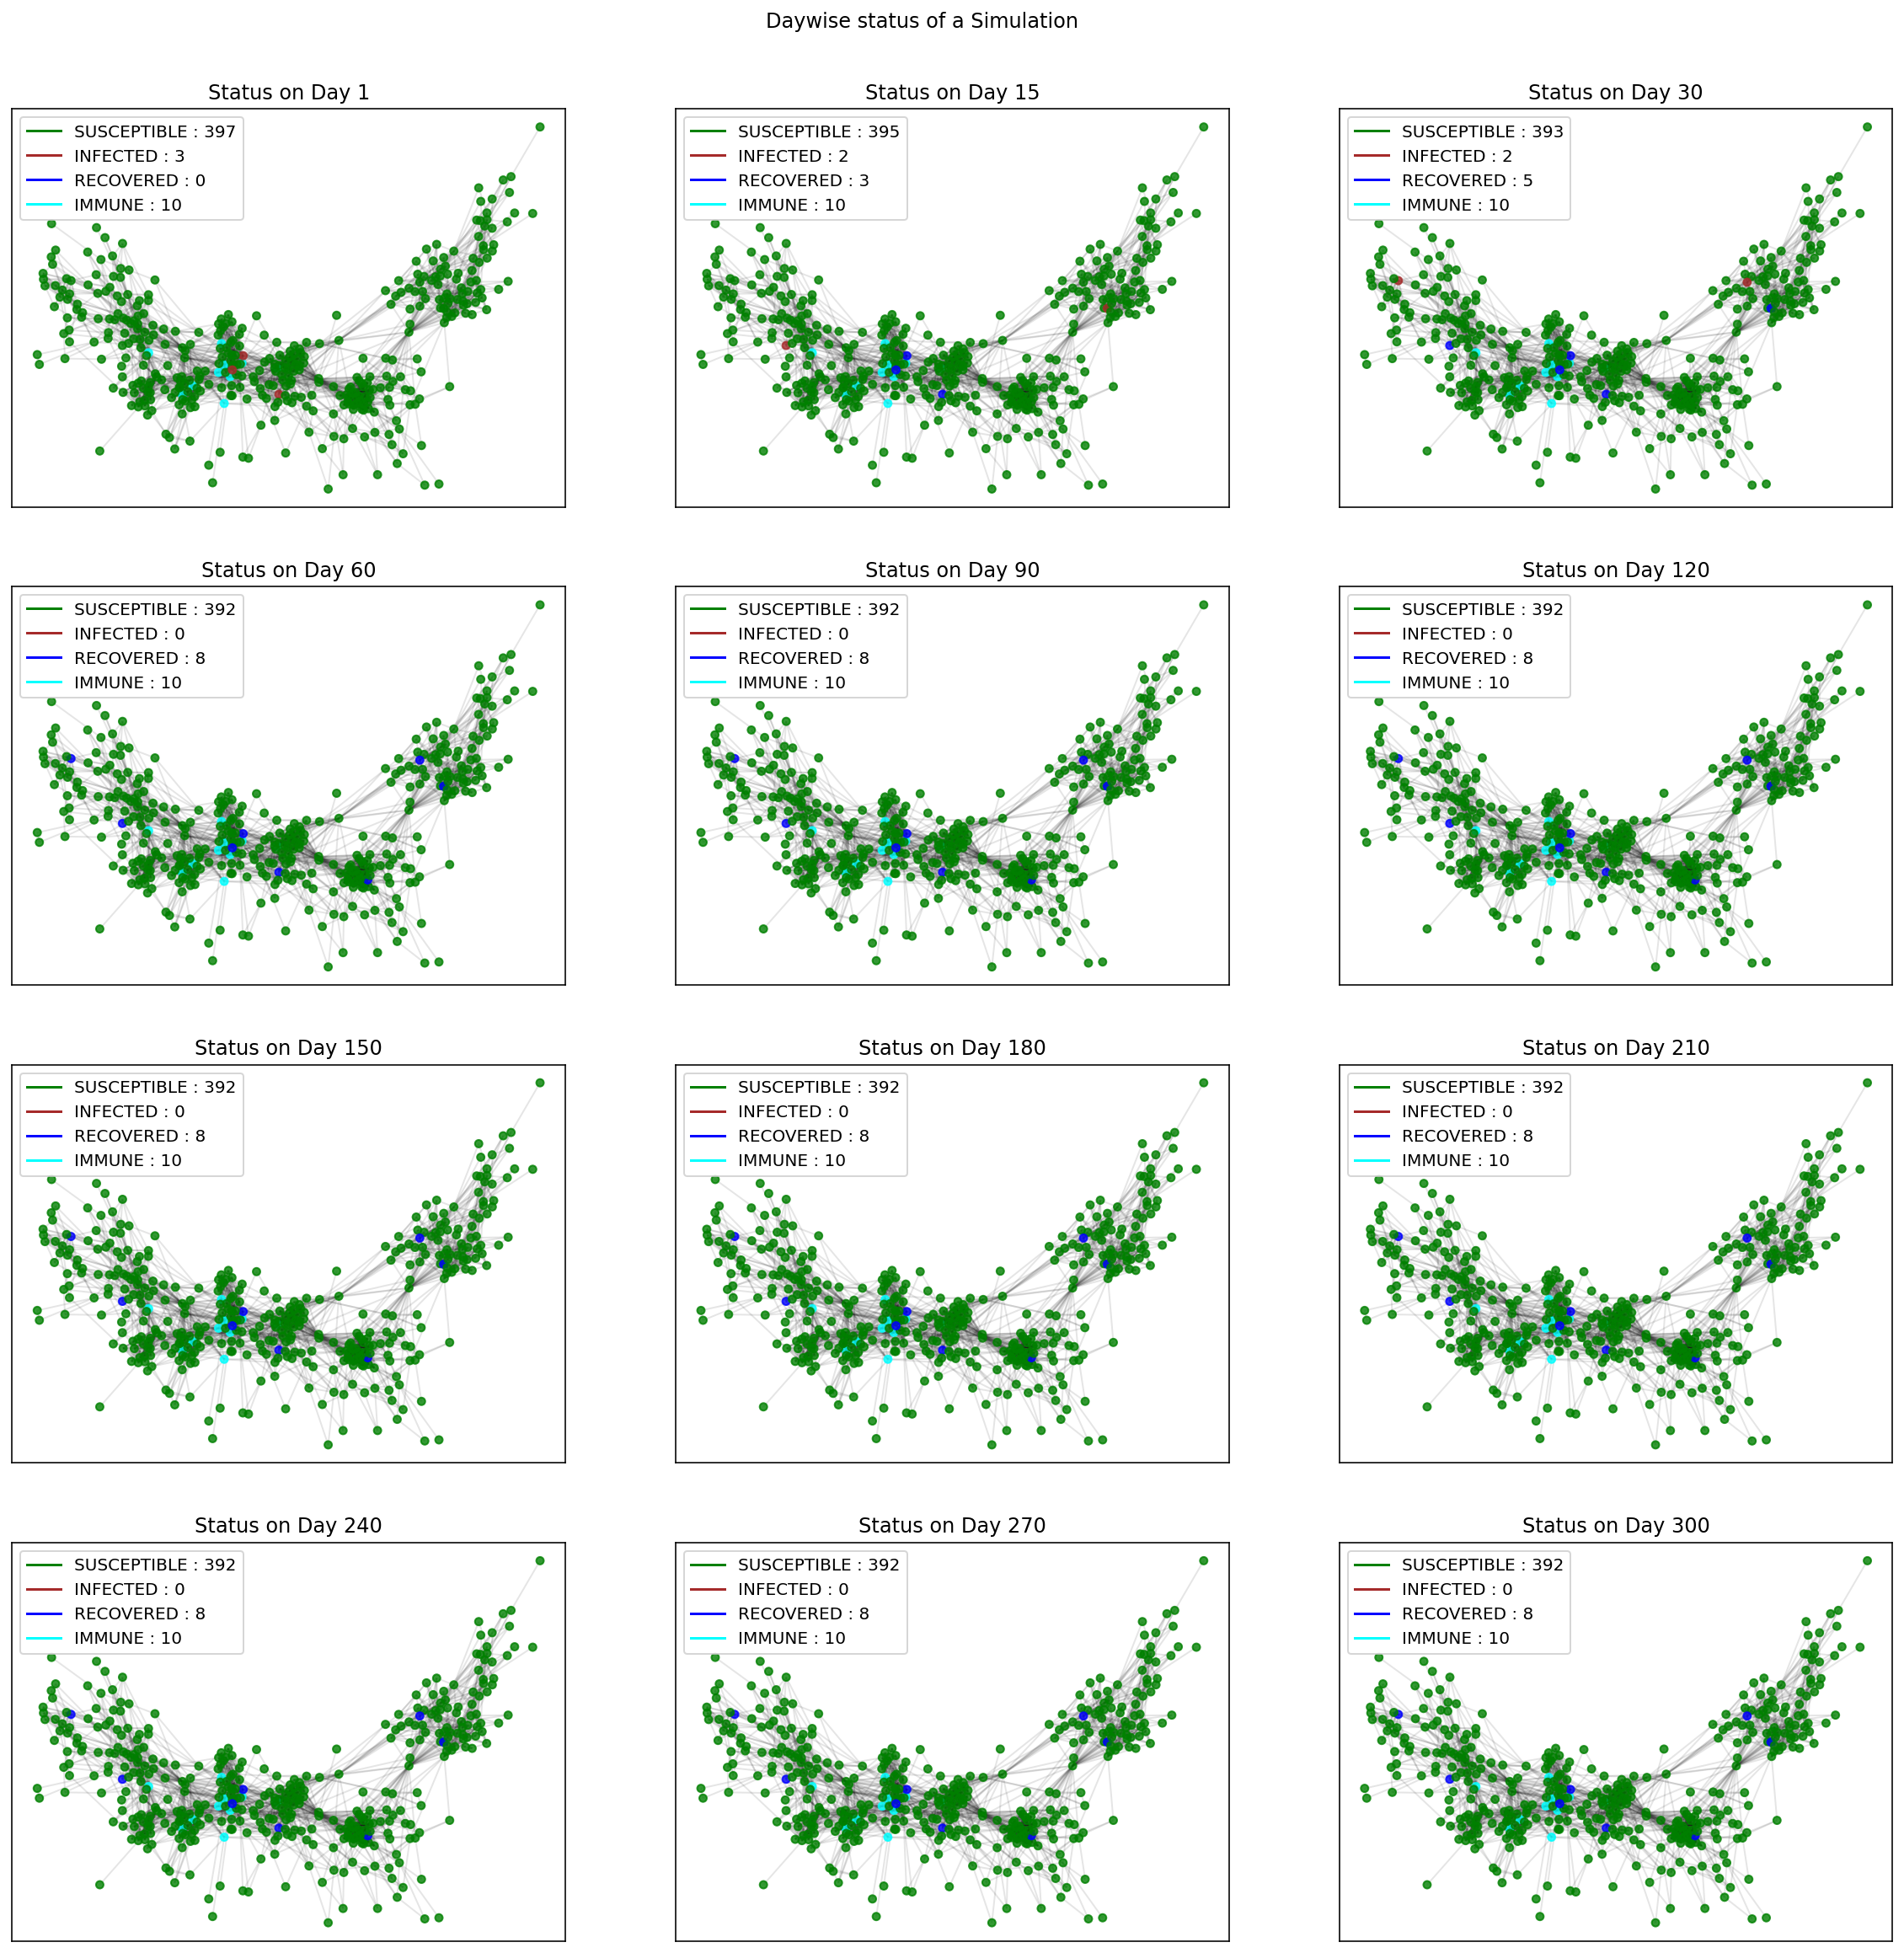

In [7]:
Gx = nx.read_edgelist('infect-dublin.edges', nodetype = int )
no_of_simulations = 100
t_simulation = 300
recovery_time = 15
beta = 0.005
immune_nodes = [1,2,3,4,5,6,7,8,9,10]
average_status_dict_SIR = simulate_SIR(Gx, no_of_simulations, t_simulation, recovery_time, beta, immune_nodes)

### SIRS/SIS Model Implementation

In [8]:
def SIRS_model(G, initial_infecteds , beta, beta2, t_simulation, recovery_time, immune_nodes):
    """
    This function performs the SIRS model simulation for a given time

    Parameters
    ----------
    G : graph
      A NetworkX graph

    initial_infecteds : list
      The list of nodes to be infected on Day 0

    beta: float
         the wave-1 transmission rate of the disease
    
    beta2: float
         the wave-2 transmission rate of the disease
         
    t_simulation : int, 
      No of days of simulation
    
    recovery_time : int
      Time taken to get recovered
      
    immune_nodes : list
      list of nodes that are immune to the disease
    
    Returns
    ----------
    overall_status_dict: dict
        the day-wise status of all nodes
    """
    recovery_time         = recovery_time
    initial_infecteds     = np.array(initial_infecteds)
    immune_nodes          = np.array(immune_nodes)
    overall_status_dict   = collections.defaultdict(list)
    infected_on_day       = np.full(len(G.nodes), -99) # setting all the nodes as not infected ever (-99)
    current_status_list   = np.full(len(G.nodes), 'S') # declaring all nodes as 'S' (SUSCEPTIBLE) initially
    nodes_wave_list       = np.full(len(G.nodes), '-99W') # declaring all nodes as 'S' (SUSCEPTIBLE) initially
    
    # Update the status of Immune / Vaccinated nodes
    current_status_list[immune_nodes -1]   = 'V'

    # Update the status of the initial infected nodes
    current_status_list[initial_infecteds -1]   = 'I'
    infected_on_day[initial_infecteds -1] = 0
    nodes_wave_list[initial_infecteds -1] = 'W1' # Indicating wave 1
    
    overall_status_dict[0] = current_status_list.copy()

    for t in range(1, t_simulation+1):
        # Get all current infected nodes' index
        infected_list = np.where(current_status_list == 'I')[0] + 1 

        #Start infection process
        for infected_node in infected_list:
            beta_updated = beta
            wave = 'W1'
            if nodes_wave_list[infected_node - 1] == 'W2':
                beta_updated = beta2
                wave = 'W2'
            if t - infected_on_day[infected_node - 1]  == recovery_time:
                current_status_list[infected_node -1 ] = 'R'
            else:
                neighbours = list(G.neighbors(infected_node)) # get list of neighbors
                for n in neighbours:
                    node_index = n-1
                    # Infecting susceptible neighbors if the beta is greater than the random number
                    if current_status_list[node_index] == 'S'or (current_status_list[node_index] =='I' \
                                                                 and nodes_wave_list[node_index] == 'W1' \
                                                                 and wave == 'W2'):
                        rand_num = np.random.uniform(0,1) # generate infection probability
                        if rand_num <= beta_updated: 
                            current_status_list[node_index] = 'I' # Update the status of the infected node
                            infected_on_day[node_index] = t 
                            nodes_wave_list[node_index] = wave
        
        # Introduce Second Wave
        if t == 100:
            second_wave_nodes = get_secondwave_nodes(current_status_list, size = 30)
            current_status_list[second_wave_nodes] = 'I'
            infected_on_day[second_wave_nodes] = t
            nodes_wave_list[second_wave_nodes] = 'W2'
            
        overall_status_dict[t] = current_status_list.copy()
    
    return overall_status_dict


def get_secondwave_nodes(current_status_list, size = 30):
    """
    This function generates a list of random node ids

    Parameters
    ----------
    current_status_list : list
      The current status of all the nodes 
         
    second_wave_nodes : list 
      the list of nodes
  
    Returns
    ----------
    overall_status_dict: dict
        the day-wise status of all nodes
    """
    rng = default_rng()
    node_list = [x for x in range(len(current_status_list)) if current_status_list[x] not in ('V', 'R')]
    second_wave_nodes = rng.choice(node_list, size = 30, replace=False)
    return np.array(second_wave_nodes)

### SIRS Model Simulation

In [9]:
def simulate_SIRS(G, no_of_simulations, t_simulation, recovery_time, beta, beta2, immune_nodes):    
    """
    This function repeats the SIRS model simulation for a given number of times

    Parameters
    ----------
    G : graph
      A NetworkX graph

    no_of_simulations : int
      No of times to repeat the simulation
     
    t_simulation : int, 
      No of days of simulation
      
    recovery_time : int
      Time taken to get recovered
    
    beta: float
         the wave-1 transmission rate of the disease
    
    beta2: float
         the wave-2 transmission rate of the disease

    immune_nodes : list
      list of nodes that are immune to the disease              
      
    Returns
    ----------
    average_status_dict_SI: dict
        the average day-wise status of all nodes on all simulations
    """
    
    start = timer() # Start timer

    # Initialising the status dictionary
    average_status_dict_SIRS = defaultdict(dict)
    for i in range(t_simulation+1):
        average_status_dict_SIRS[i] = {'S': 0, 'I' : 0, 'R' : 0}

    # Calculating daily average 
    for i in range(no_of_simulations):
        initial_infecteds = np.random.choice(len(G.nodes), 3)
        overall_status_dict_SIRS = SIRS_model(G, initial_infecteds = initial_infecteds, 
                                            beta = beta, beta2 = beta2, t_simulation = t_simulation, 
                                            recovery_time = recovery_time, immune_nodes = immune_nodes)

        for time, status in overall_status_dict_SIRS.items():
            average_status_dict_SIRS[time]['S'] += Counter(status).get('S', 0)
            average_status_dict_SIRS[time]['I'] += Counter(status).get('I', 0)
            average_status_dict_SIRS[time]['R'] += Counter(status).get('R', 0)
    end = timer() # End timer

    print(f"No of Simulations: {no_of_simulations} \nTime taken: {round(end - start, 2)} Seconds")

    
    pos = nx.spring_layout(G)
    draw_SIR_summary_plot(average_status_dict_SIRS, no_of_simulations, 'SIRS Model') # Plot the final Summary
    draw_SIR_model_progress(G, pos, overall_status_dict_SIRS) # Plot daily status of a random simulation
    return average_status_dict_SIRS

No of Simulations: 100 
Time taken: 16.28 Seconds


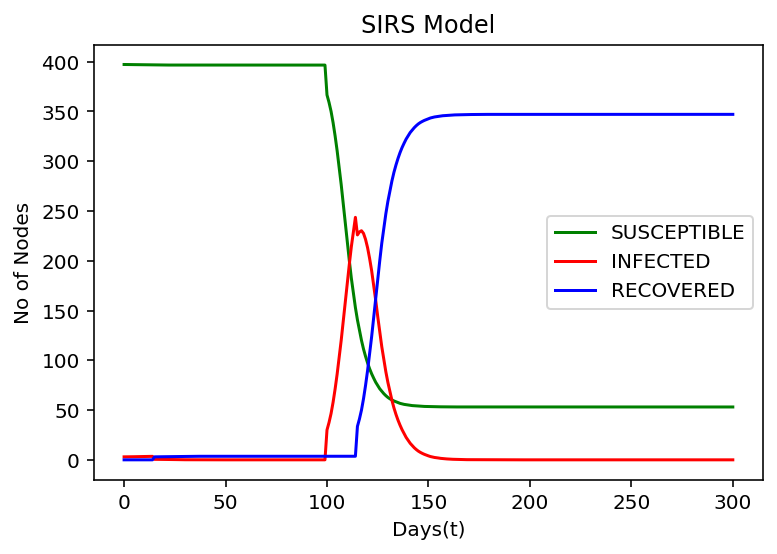

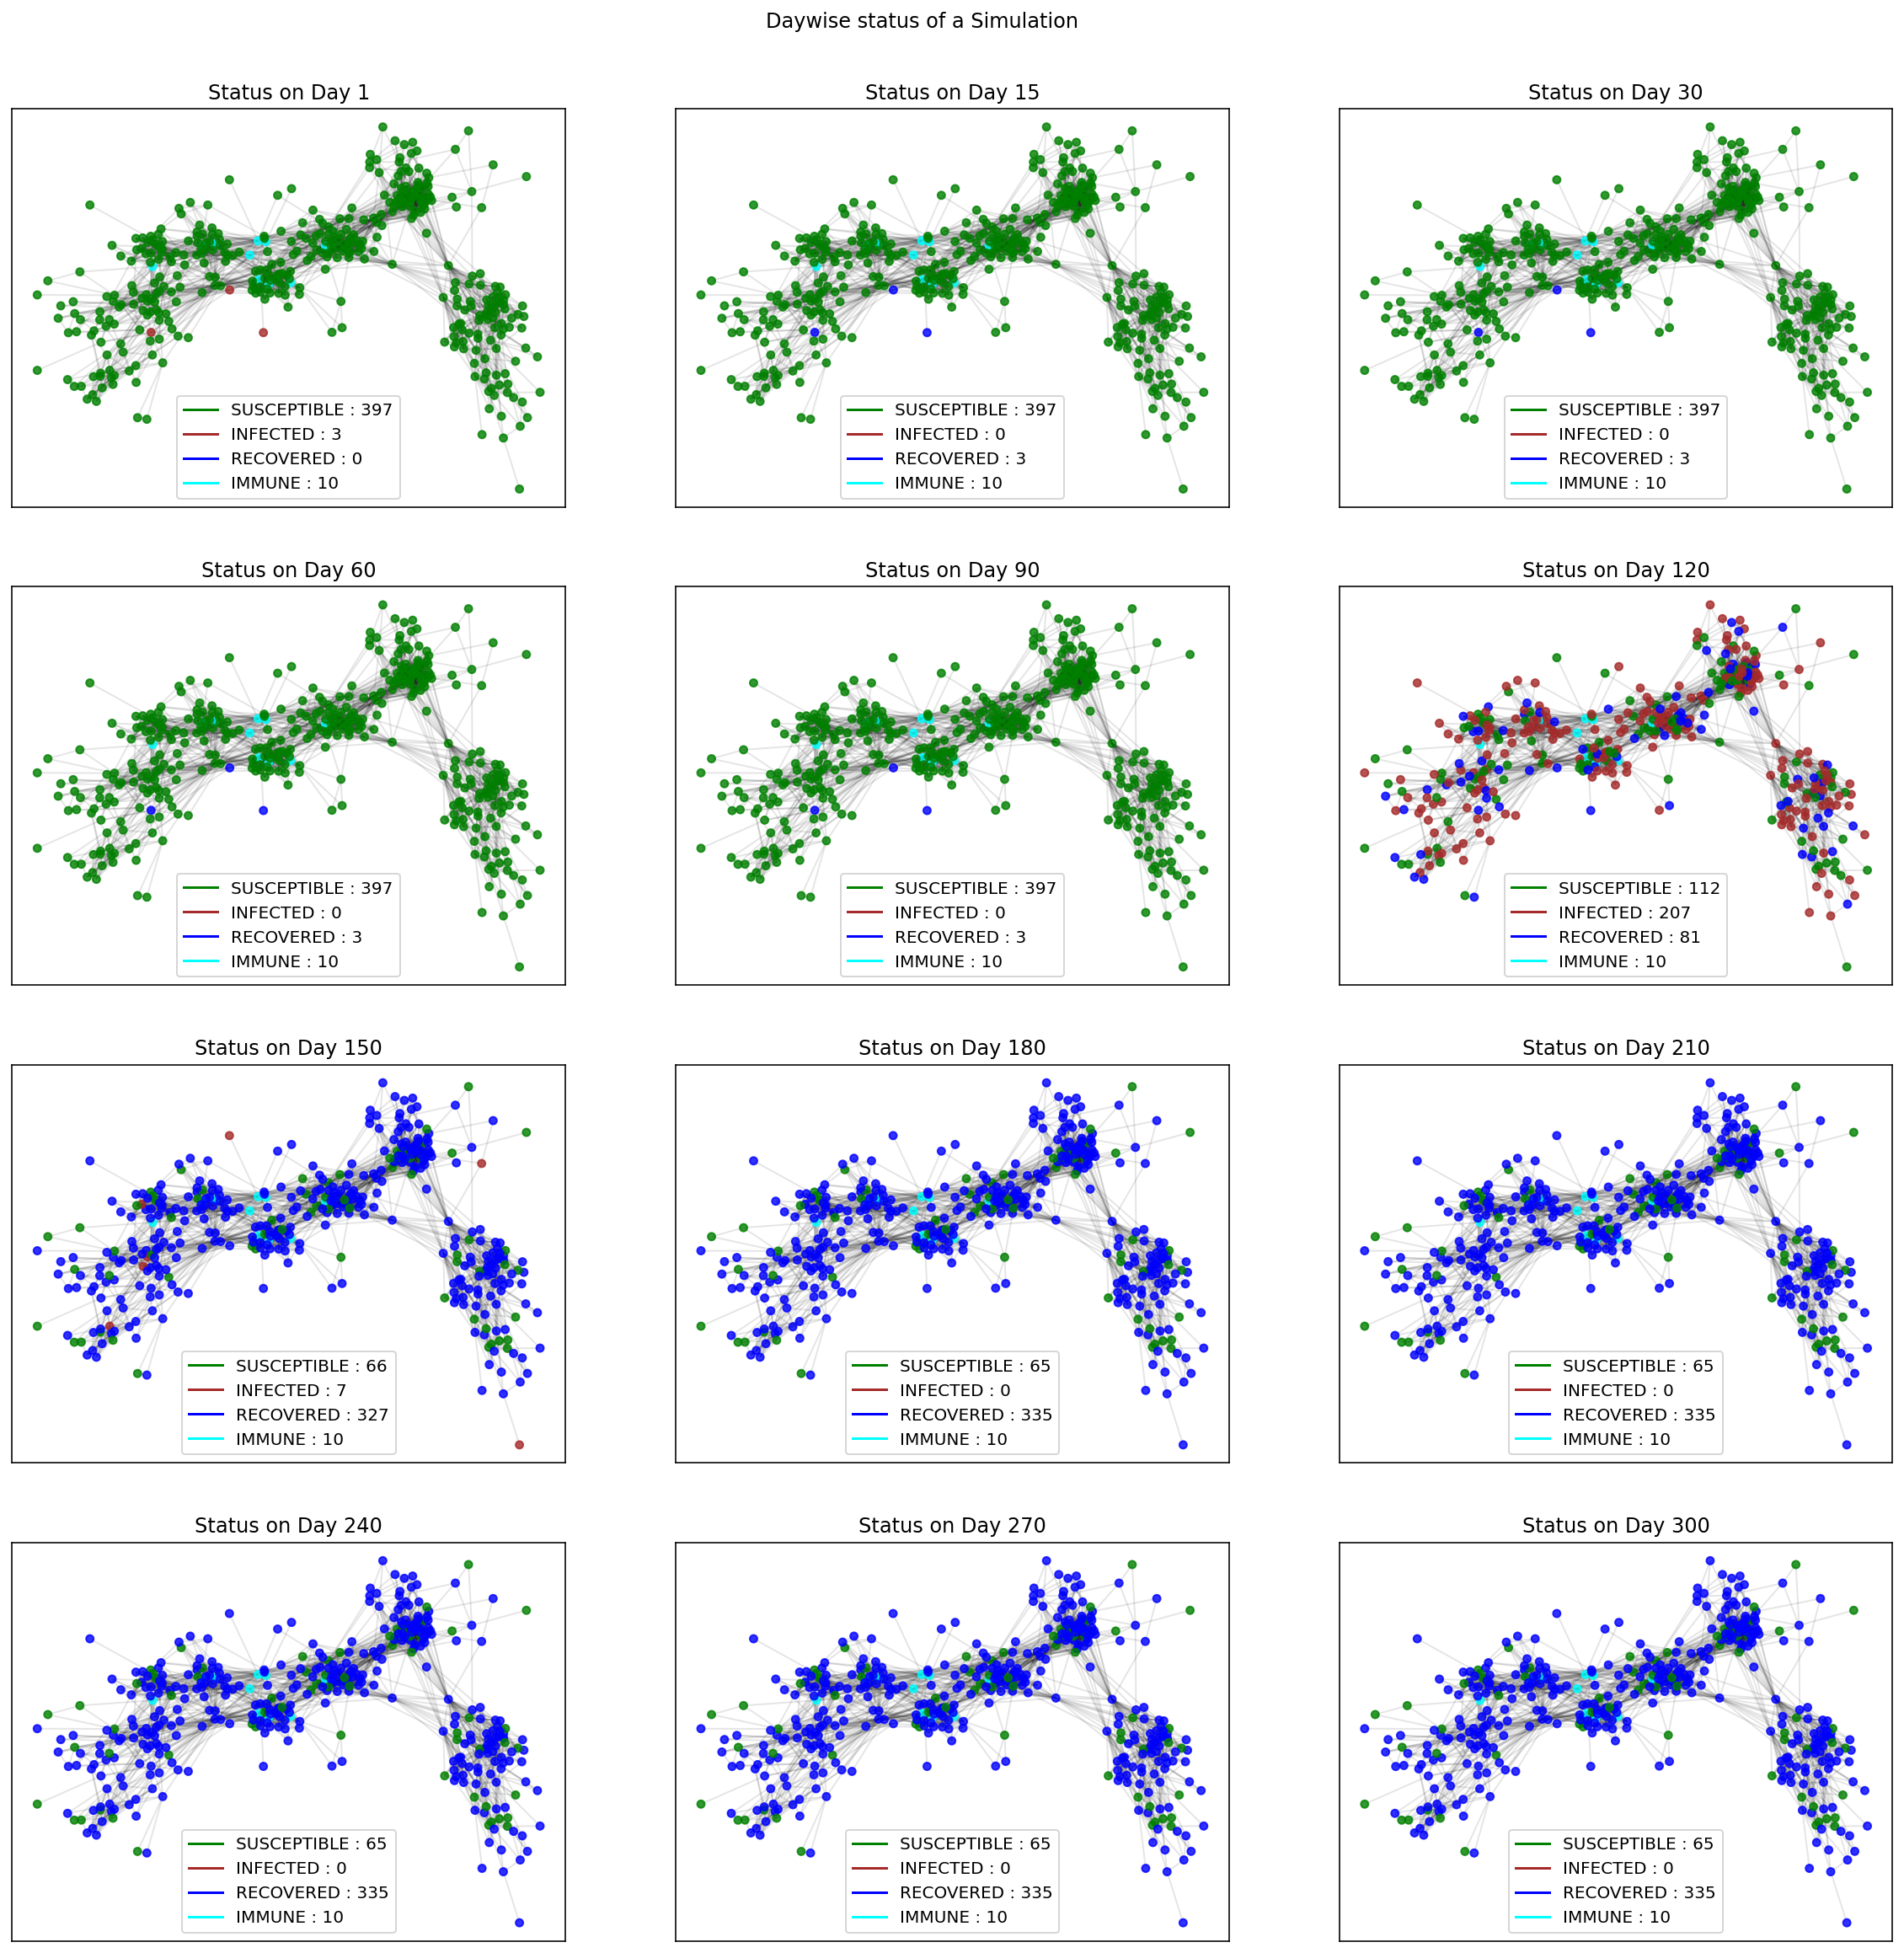

In [10]:
Gx = nx.read_edgelist('infect-dublin.edges', nodetype = int )
no_of_simulations = 100
t_simulation = 300
start = timer()
recovery_time = 15
beta = 0.001
beta2 = 0.02
immune_nodes = [1,2,3,4,5,6,7,8,9,10]
average_status_dict_SIRS = simulate_SIRS(Gx, no_of_simulations, t_simulation, recovery_time, beta, beta2, immune_nodes)

In [11]:
def draw_final_summary(average_status_dict_SI, average_status_dict_SIR, \
                       average_status_dict_SIRS, no_of_simulations):
    """
    This function plots the overall summary of SI, SIR and SIRS models

    Parameters
    ----------

    no_of_simulations : int
      No of times to repeat the simulation

    average_status_dict_SI: dict
        the average day-wise status of all nodes on all simulations in SI Model

    average_status_dict_SIR: dict
        the average day-wise status of all nodes on all simulations in SIR Model

    average_status_dict_SIRS: dict
        the average day-wise status of all nodes on all simulations in SIRS Model
    """
    
    no_of_simulations = no_of_simulations
    SI_S_Data, SI_I_Data  = [], []
    SIR_S_Data, SIR_R_Data, SIR_I_Data = [], [], []
    SIS_S_Data, SIS_R_Data, SIS_I_Data = [], [], []

    # Calculate the average daily status of all nodes in SI simulation
    for t, status in average_status_dict_SI.items():
        status_on_day_t = collections.Counter(status)
        SI_S_Data.append(status_on_day_t['S']/no_of_simulations)
        SI_I_Data.append(status_on_day_t['I']/no_of_simulations)

    # Calculate the average daily status of all nodes in SIR simulation
    for t, status in average_status_dict_SIR.items():
        status_on_day_t = collections.Counter(status)
        SIR_S_Data.append(status_on_day_t['S']/no_of_simulations)
        SIR_I_Data.append(status_on_day_t['I']/no_of_simulations)
        SIR_R_Data.append(status_on_day_t['R']/no_of_simulations)

    # Calculate the average daily status of all nodes in SIRS simulation
    for t, status in average_status_dict_SIRS.items():
        status_on_day_t = collections.Counter(status)
        SIS_S_Data.append(status_on_day_t['S']/no_of_simulations)
        SIS_I_Data.append(status_on_day_t['I']/no_of_simulations)
        SIS_R_Data.append(status_on_day_t['R']/no_of_simulations)

    # Plot SI vs SIR data
    plt.figure(figsize = (6,4))
    plt.title('FIGURE1 -- SI : SIR Model Output')
    plt.xlabel('Days(t)')
    plt.ylabel('No of Nodes')
    plt.plot(range(0, t_simulation+1), SI_S_Data, label="SI: S", color = 'g')
    plt.plot(range(0, t_simulation+1), SI_I_Data, label="SI: I", color='r')

    plt.plot(range(0, t_simulation+1), SIR_S_Data, label="SIR: S", color = 'g', linestyle = '-.')
    plt.plot(range(0, t_simulation+1), SIR_I_Data, label="SIR: I", color = 'r', linestyle = '-.')
    plt.plot(range(0, t_simulation+1), SIR_R_Data, label="SIR: R", color = 'b', linestyle = '-.')
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
    plt.show()


    # Plot SI vs SIS data
    plt.figure(figsize = (6,4))
    plt.title('FIGURE2 -- SI : SIRS Model Output')
    plt.xlabel('Days(t)')
    plt.ylabel('No of Nodes')
    plt.plot(range(0, t_simulation+1), SI_S_Data, label="SI: S", color = 'g')
    plt.plot(range(0, t_simulation+1), SI_I_Data, label="SI: I", color='r')

    plt.plot(range(0, t_simulation+1), SIS_S_Data, label="SIR: S", color = 'g', linestyle = '-.')
    plt.plot(range(0, t_simulation+1), SIS_I_Data, label="SIR: I", color = 'r', linestyle = '-.')
    plt.plot(range(0, t_simulation+1), SIS_R_Data, label="SIR: R", color = 'b', linestyle = '-.')
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
    plt.show()
   
    # Plot SI vs SIS second wave data
   
    # Plot the first 200 days of SI status vs SIS second wave data(100th day to 300th day) 
    index = 99 # setting the index for SIS data
    SIS_S_Data = SIS_S_Data[index:]
    SIS_I_Data = SIS_I_Data[index:]
    SIS_R_Data = SIS_R_Data[index:] 
    SI_S_Data  = SI_S_Data[:200]
    SI_I_Data  = SI_I_Data[:200]
    
    # Plot the Graph
    plt.figure(figsize = (6,4))
    plt.title('FIGURE3 -- SI : Second Wave ')
    plt.xlabel('Days elapsed')
    plt.ylabel('No of Nodes')
    # Plot SI Data
    plt.plot(range(0, 200), SI_S_Data, label="SI: S", color = 'g')
    plt.plot(range(0, 200), SI_I_Data, label="SI: I", color='r')
    # Plot SIS Data
    plt.plot(range(0, t_simulation+1-index), SIS_S_Data, label="SIS: S", color = 'g', linestyle = '-.')
    plt.plot(range(0, t_simulation+1-index), SIS_I_Data, label="SIS: I", color = 'r', linestyle = '-.')
    plt.plot(range(0, t_simulation+1-index), SIS_R_Data, label="SIS: R", color = 'b', linestyle = '-.')
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
    plt.show()

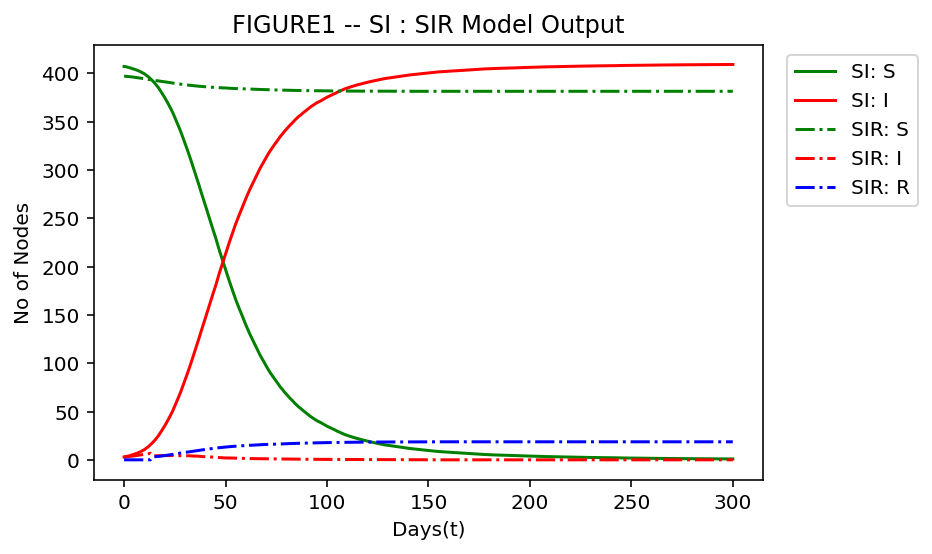

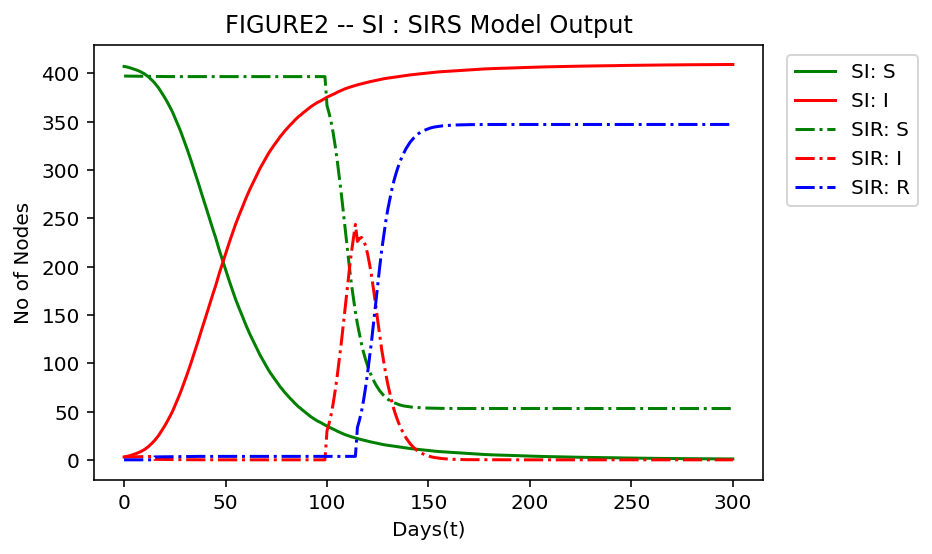

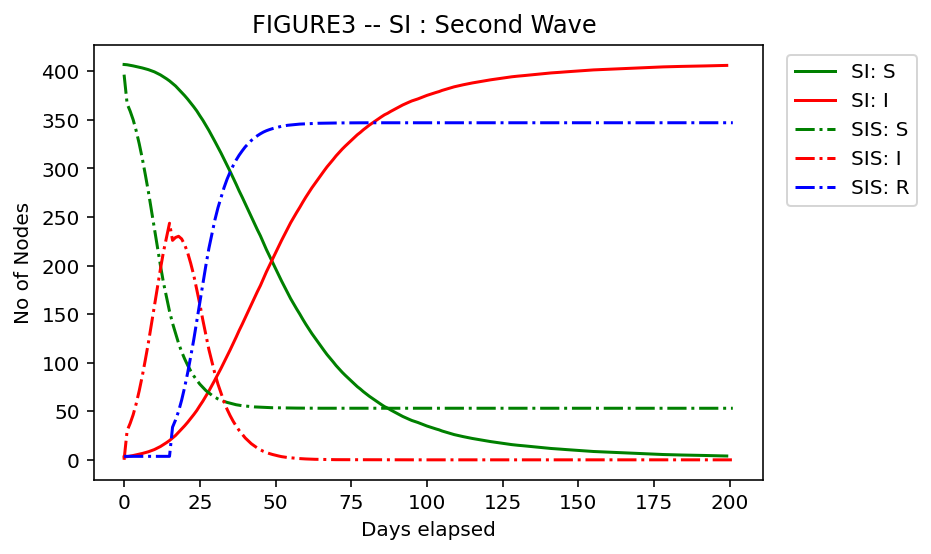

In [12]:
draw_final_summary(average_status_dict_SI, average_status_dict_SIR,  average_status_dict_SIRS, no_of_simulations)

## Comparitive Study and Remarks
- <b>If recovery is allowed (SIR and SIS models), the number of infections follow a normal distribution.</b>
- As soon as there is an increase in the number of infections on day "t", 
    - there is bound to be a decrease in the number of susceptible on the same day - day "t"
    - there will also be an increase in the number of recoveries from day "t"+15


<b>SI Model:</b>
- The no of infections keep increasing because there's no way for a node to get recovered
- If we run the simulation for long enough, all the nodes will be infected

<b>SIR Model:</b>
- Because of less transmission rate, the SIR model struggles to spread the disease for the first 100 days. 
- Even after the end of simulation, Nodes CAN be left susceptible no matter how many days we run the simulation because:
    - All the infected nodes will eventually recover
    - If the infected nodes do not spread the disease(based on random probability), then after all the nodes recover, there's no way to spread the disease. This is what is happened in our SIR simulation - until day 100 from almost after day 25, there is almost no new infection 

<b>SIRS Model:</b>
- After the second wave is introduced, the spreading gets faster and no. of infections increase not only because of it's high transmission but also because we infected a whooping 7.5% of population(30 nodes) on a single day, which results in a faster spread


In the above graph, we can see that:
- In Figure 1, the infection rate is very less because the beta is 0.005 and hence, after the initial few infected nodes are recovered, the model ceased to spread because all the infected nodes are recovered with out having the chance to infect new nodes - due to less transmission rate.
- In Figure 2, we can see that there is a sudden low steep in the susceptible curve and an up steep in the infected curve  at the same time - starting from day 100. This is because we've introduced the second wave which transmits faster than the first wave. Hence, more nodes start to get infected.
- We can also see the recover curve starting to steep up from day 115 because the nodes who gor infected on day 100 are recovered on this day. Hence, the curve also goes up.
- Figure 3 is drawn in such a way that it's easier to compare the SI and SIS models. While SI model has been plotted from Day 0 to Day 200, SIR model has been plotted from Day 100 to Day 300 which is equivalent to Day 0 to Day 200 of Second Wave.
 - We can see from Figure 3 that because the rate of spread is higher than that of SIR wave 1, maximum number of infections happened approximately with in the first 25 days after second wave. 
     - The reduction in the no of infections in the SIS model after ~day 15 is because until day 15, there is no node from second wave that's getting recovered but there are new nodes that are getting infected.
     - After day 15, recovery process starts and gradually the no of infections on a given day starts to reduce because almost all the neighbors of the infected nodes are already infected